In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector as db_conn
import calendar

### Establish the connection to the db and return the conn and cursor

In [2]:
def establish_db_conn() -> tuple:
    """
        Parameters explained: 
            None 

        Return values:
            Tuple which contains the connection object (conn) and the cursor object (conn.cursor()).

        Explanation of function: 
            This function is making the initial one-time connection to the database 'creditcard_capstone' and returning a 
            connection object and a cursor object that will be used to execute sql queries. 
    """
    # make connection
    conn = db_conn.connect(
        host='localhost',
        database='creditcard_capstone',
        user='root',
        password='password'
    )
    # make and return the cursor object
    return conn, conn.cursor()
conn, cursor = establish_db_conn()

## 1. Calculate and plot which transaction type has the highest transaction count.

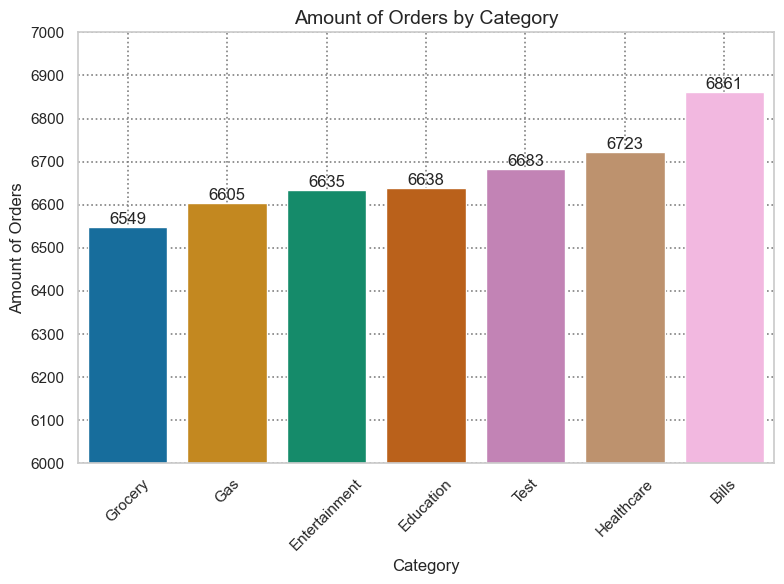

In [10]:
def plot_transaction_count_data(cursor: object) -> None:
    cursor.execute(
        """
            select transaction_type, count(transaction_id) as orders, sum(transaction_value)
            from cdw_sapp_credit_card
            group by transaction_type
            order by orders; 
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["Category", "Amount of Orders", "Total of Orders"])

    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=df, x="Category", y="Amount of Orders", hue="Category", palette="colorblind")

    # Add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%d')

    plt.title("Amount of Orders by Category", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 7500, 100))
    ax.set_ylim(6000, 7000)
    plt.grid(True, linestyle=':', linewidth=1.2, color='gray') 
    plt.tight_layout()
    plt.show()
plot_transaction_count_data(cursor)

## 2. Calculate and plot the top 10 states with the highest number of customers.

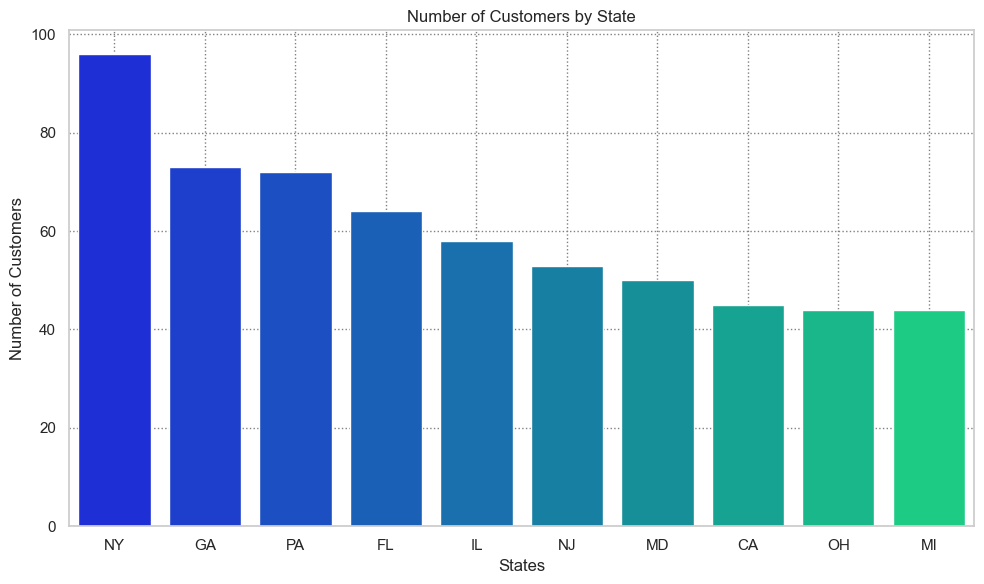

In [27]:
def plot_customer_density(cursor: object) -> None:
    cursor.execute(
        """
            select cust_state, count(ssn)
            from cdw_sapp_customer
            group by cust_state
            order by count(ssn) desc
            limit 10;
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["State", "Number of Customers"])
    # Bar plot of customers per state
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="State", y="Number of Customers",hue="State", palette="winter")
    plt.xlabel(xlabel="States")
    plt.title("Number of Customers by State")
    plt.grid(True, linestyle=':', linewidth=1, color='gray') 
    plt.tight_layout()
    plt.show()
plot_customer_density(cursor)

## 3. Calculate the total transaction sum for each customer based on their individual transactions. Identify the top 10 customers with the highest transaction amounts (in dollar value). Create a plot to showcase these top customers and their transaction sums.

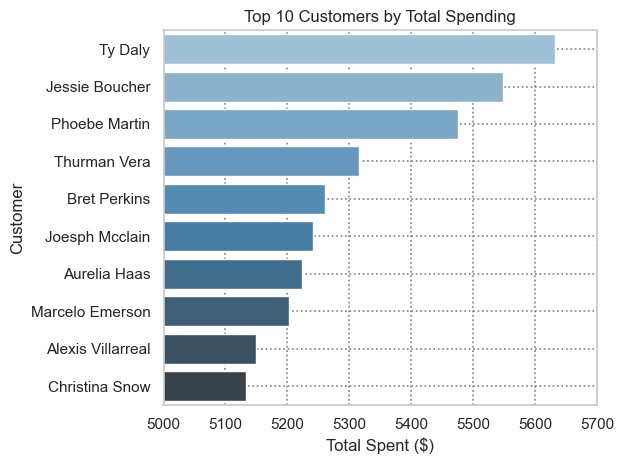

In [82]:
def display_top_10_customers(cursor: object) -> None:
    cursor.execute(
        """
            select cu.first_name, cu.last_name, sum(cc.transaction_value) as total
            from cdw_sapp_credit_card cc
            left join cdw_sapp_customer cu on cc.cust_ssn = cu.ssn
            group by cust_ssn
            order by total desc
            limit 10;
        """
    )
    
    df = pd.DataFrame(cursor.fetchall(), columns=["First Name", "Last Name", "Total"])
    # combine full name
    df["Customer"] = df["First Name"] + " " + df["Last Name"]

    ax = sns.barplot(data=df, y="Customer", x="Total", hue="Customer", palette="Blues_d")

    # Plot
    plt.title("Top 10 Customers by Total Spending")
    plt.xlabel("Total Spent ($)")
    plt.ylabel("Customer")
    ax.set_xlim(5000, 5700)  # Zoom in on x-axis since bars run horizontally
    plt.grid(True, linestyle=':', linewidth=1.2, color='gray')
    plt.tight_layout()
    plt.show()
display_top_10_customers(cursor)


## 4. Calculate and plot the percentage of applications approved for self-employed applicants. Use the appropriate chart or graph to represent this data.

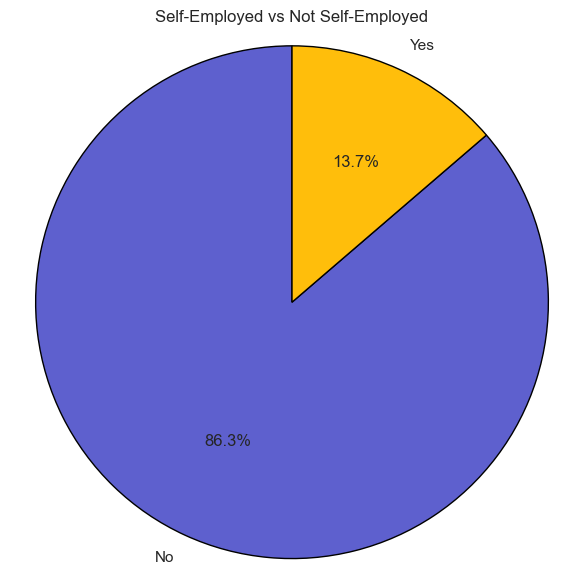

In [6]:
def display_self_employed_apps(cursor: object) -> None:
    cursor.execute(
        """
            select self_employed
            from cdw_sapp_loan_application
            order by self_employed;
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["Self Employed"])
    counts = df["Self Employed"].value_counts()

    # Create pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=["#5e60ce", "#ffbe0b"],  # Optional: green for yes, red for no
        wedgeprops={'edgecolor': 'black'}
    )

    plt.title("Self-Employed vs Not Self-Employed")
    plt.axis('equal')  # Keep it circular
    plt.tight_layout()
    plt.show()
display_self_employed_apps(cursor)

## 5. Calculate the percentage of rejection for married male applicants. Use the ideal chart or graph to represent this data.

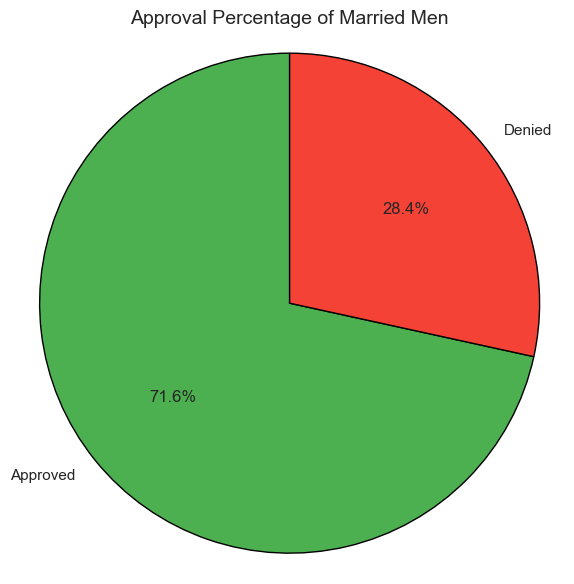

In [7]:
def plot_rejected_male_apps(cursor: object) -> None:
    cursor.execute(
        """
            select application_status
            from cdw_sapp_loan_application
            where gender = 'male' and married = 'Yes';
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["Status"])
    # map 'Y' and 'N' to readable labels
    df['Claim Status'] = df['Status'].replace({'Y': 'Approved', 'N': 'Denied'})

    # count values
    status_counts = df['Claim Status'].value_counts()

    # plot pie chart
    colors = ["#4CAF50", "#F44336"]  # Green for approved, red for denied

    plt.figure(figsize=(6, 6))
    plt.pie(
        status_counts,
        labels=status_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'black'}
    )

    plt.title("Approval Percentage of Married Men", fontsize=14)
    plt.axis('equal') 
    plt.tight_layout()
    plt.show()
plot_rejected_male_apps(cursor)

## 6. Calculate and plot the top three months with the largest volume of transaction data. Use the ideal chart or graph to represent this data.

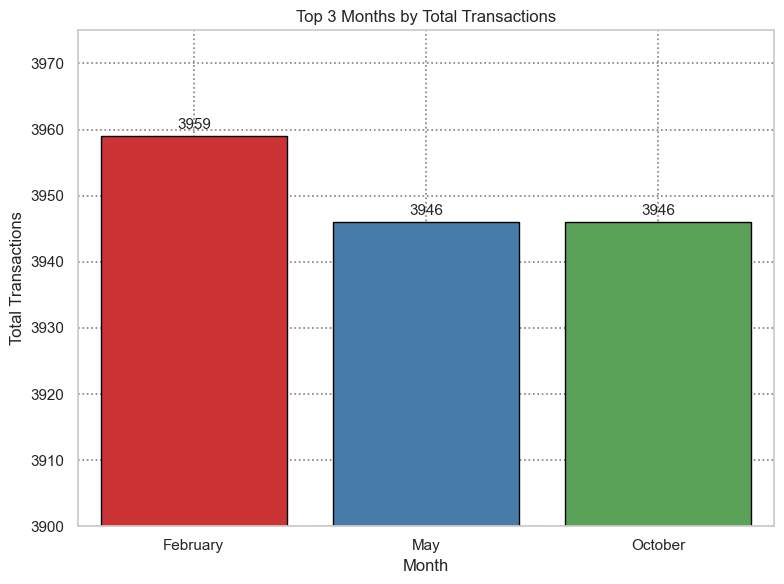

In [ ]:
def plot_top_three_months(cursor: object) -> None:
    # count(transaction_id) was used over sum(transaction_value) because the question was asking for volume not sum or revenue etc. 
    cursor.execute(
        """
            select month(timeid), count(transaction_id) as total
            from cdw_sapp_credit_card
            group by month(timeid)
            order by total desc
            limit 3;
        """
    )

    
    df = pd.DataFrame(cursor.fetchall(), columns=["Month", "Total Transactions"])
    df["Month"] = df["Month"].apply(lambda x: calendar.month_name[int(x)])

    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=df, x="Month", y="Total Transactions", hue="Month", palette="Set1", edgecolor="black")

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3, fontsize=11)

    plt.title("Top 3 Months by Total Transactions")
    plt.xlabel("Month")
    plt.ylabel("Total Transactions")
    ax.set_ylim(3900, 3975)  # zoom in on the y-axis to exaggerate differences
    plt.grid(True, linestyle=':', linewidth=1.2, color='gray')
    plt.tight_layout()
    plt.show()

plot_top_three_months(cursor)

## 7. Calculate and plot which branch processed the highest total dollar value of healthcare transactions. Use the ideal chart or graph to represent this data.

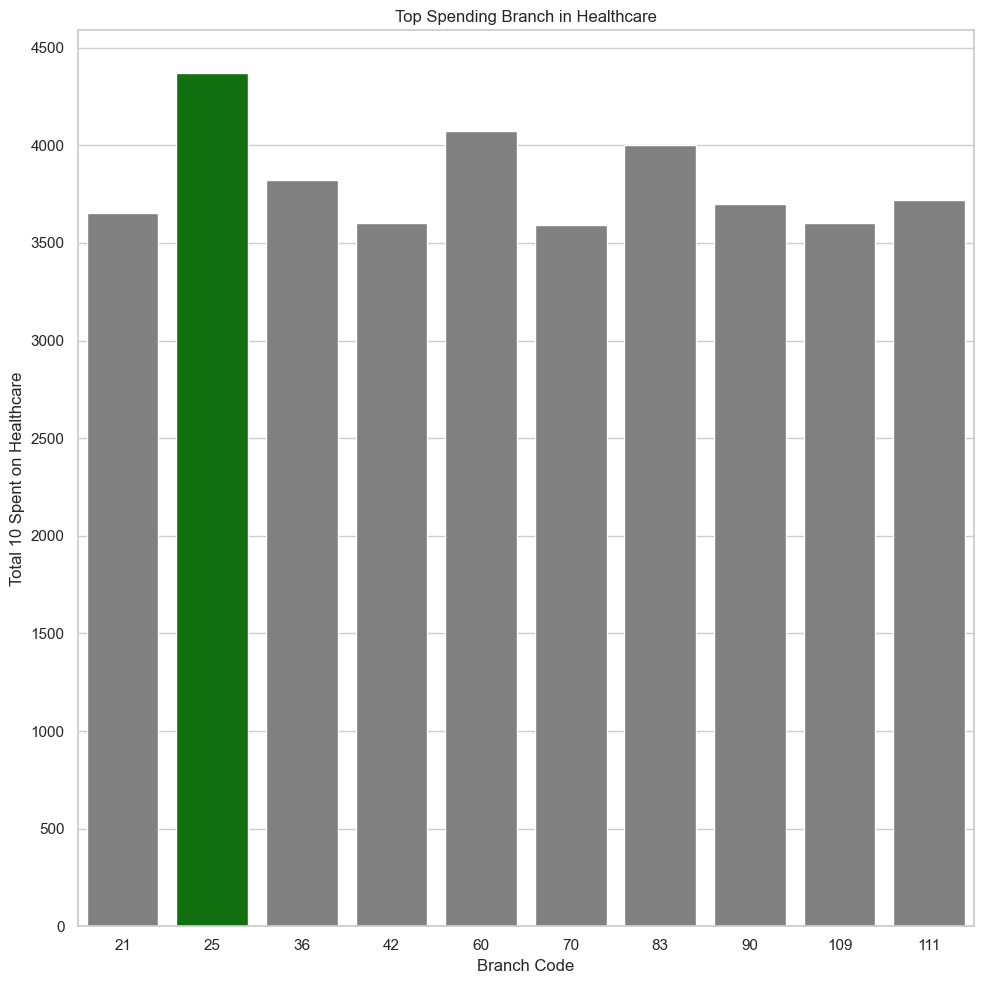

In [20]:
def plot_healthcare_transactions(cursor: object) -> None:
    cursor.execute(
        """
            select cb.branch_code, sum(cc.transaction_value)
            from cdw_sapp_credit_card cc 
            left join cdw_sapp_branch cb on cc.branch_code = cb.branch_code
            where cc.transaction_type = 'Healthcare'
            group by cb.branch_code
            order by sum(cc.transaction_value) desc
            limit 10;
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["Branch Code", "Total Spent on Healthcare"])

    df_sorted = df.sort_values("Total Spent on Healthcare", ascending=False)

    top_spender = df_sorted.iloc[0]

    # Create a column that highlights the top spender
    df_sorted['highlight'] = df_sorted['Branch Code'] == top_spender['Branch Code']

    # Plot the horizontal bar chart
    plt.figure(figsize=(10, 10))
    sns.barplot(
        data=df_sorted,
        x="Branch Code",
        y="Total Spent on Healthcare",
        hue="highlight",  # Use hue to highlight the top spender
        palette={True: "green", False: "gray"},  # Highlight the top spender in green
        dodge=False
    )

    # Title and labels
    plt.title("Top Spending Branch in Healthcare")
    plt.xlabel("Branch Code")
    plt.ylabel("Total 10 Spent on Healthcare")
    plt.yticks(range(0, 5000, 500))
    plt.tight_layout()

    # Remove the legend (since we already have color for top spender)
    plt.legend([], [], frameon=False)

    # Show the plot
    plt.show()


plot_healthcare_transactions(cursor)

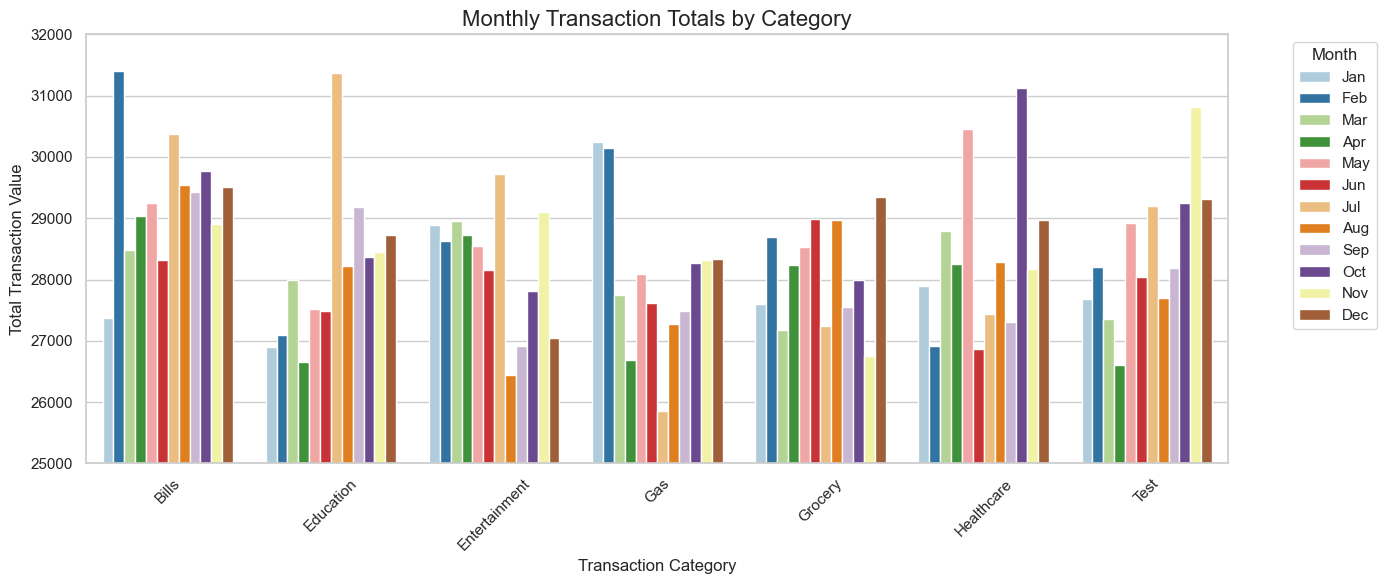

In [ ]:
def test_visual_one(cursor: object) -> None:
    cursor.execute(
        """
            select month(timeid), transaction_type, sum(transaction_value)
            from cdw_sapp_credit_card
            group by month(timeid), transaction_type
            order by month(timeid);
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["Month", "Category", "Monthly Total"])

     # Set plot style
    sns.set_theme(style="whitegrid")

    # Convert month number to string name 
    df["Month"] = df["Month"].apply(lambda x: pd.to_datetime(f'2024-{x}-01').strftime('%b'))

    # Plot
    plt.figure(figsize=(14, 6))
    ax=sns.barplot(data=df, x="Category", y="Monthly Total", hue="Month", palette="Paired")

    plt.title("Monthly Transaction Totals by Category", fontsize=16)
    plt.xlabel("Transaction Category")
    plt.ylabel("Total Transaction Value")
    plt.xticks(rotation=45)
    ax.set_ylim(25000, 32000)
    plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

test_visual_one(cursor)

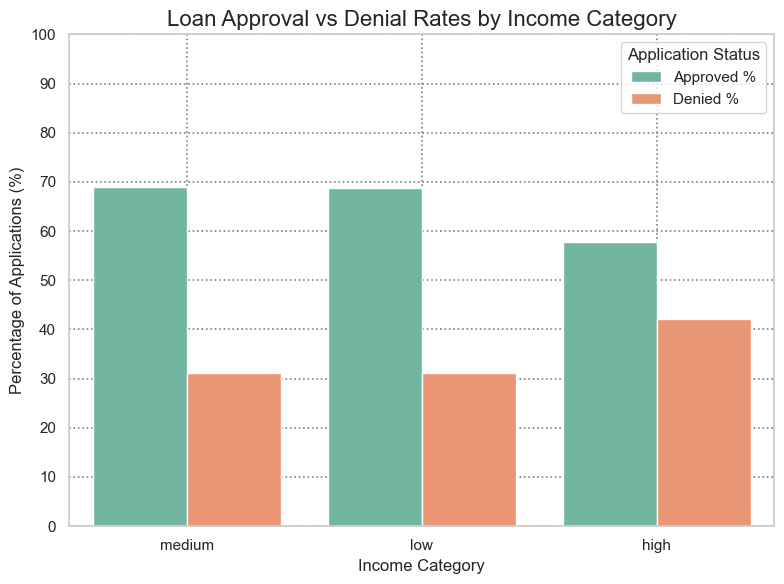

In [31]:
def test_visual_two(cursor: object) -> None:
    cursor.execute(
        """
            select income,
                count(case when application_status = 'Y' then 1 end) as Approved,
                count(case when application_status = 'N' then 1 end) as Denied
            from cdw_sapp_loan_application
            group by income
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["Income Category", "Approved", "Denied"])

    # Calculate totals and percentages
    df["Total"] = df["Approved"] + df["Denied"]
    df["Approved %"] = (df["Approved"] / df["Total"]) * 100
    df["Denied %"] = (df["Denied"] / df["Total"]) * 100

    # Reshape for plotting
    df_percent = df[["Income Category", "Approved %", "Denied %"]].melt(
        id_vars="Income Category",
        var_name="Application Status",
        value_name="Percentage"
    )

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df_percent, x="Income Category", y="Percentage", hue="Application Status", palette="Set2")

    plt.title("Loan Approval vs Denial Rates by Income Category", fontsize=16)
    plt.ylabel("Percentage of Applications (%)")
    plt.xlabel("Income Category")
    plt.ylim(0, 100)
    plt.yticks(range(0, 110, 10))
    plt.grid(True, linestyle=':', linewidth=1.2, color='gray')
    plt.legend(title="Application Status")
    plt.tight_layout()
    plt.show()

test_visual_two(cursor)

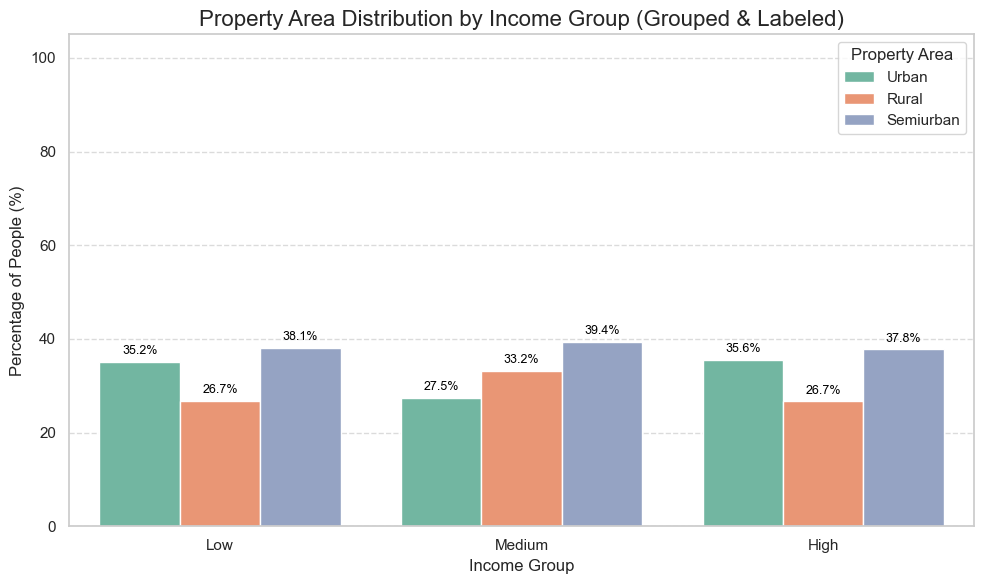

In [39]:
def test_visual_three(cursor: object) -> None:
    cursor.execute(
        """
            select property_area, 
                count(case when income = "low" then 1 end) as low,
                count(case when income = "medium" then 1 end) as medium,
                count(case when income = "high" then 1 end) as high
            from cdw_sapp_loan_application
            group by property_area;
        """
    )

    df = pd.DataFrame(cursor.fetchall(), columns=["Property Area", "Low", "Medium", "High"])

    # Normalize: get % distribution of each income group across property areas
    df_transposed = df.set_index("Property Area").T
    df_percent = df_transposed.div(df_transposed.sum(axis=1), axis=0) * 100
    df_percent.reset_index(inplace=True)
    df_percent = df_percent.rename(columns={"index": "Income Group"})

    # Melt to long format for Seaborn
    df_melted = df_percent.melt(id_vars="Income Group", 
                                var_name="Property Area", 
                                value_name="Percentage")

    # Plot setup
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Draw barplot
    ax = sns.barplot(data=df_melted,
                     x="Income Group", 
                     y="Percentage", 
                     hue="Property Area", 
                     palette="Set2")

    # Add value labels on bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2, 
                    height + 1, 
                    f"{height:.1f}%", 
                    ha="center", 
                    va="bottom", 
                    fontsize=9, 
                    color="black")

    # Final formatting
    plt.title("Property Area Distribution by Income Group (Grouped & Labeled)", fontsize=16)
    plt.ylabel("Percentage of People (%)")
    plt.xlabel("Income Group")
    plt.ylim(0, 105)
    plt.legend(title="Property Area")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
test_visual_three(cursor)